# **Task \#2**: Machine Learning MC886/MO444
##**Classical Machine Learning Techniques**##

In [1]:
print('Daniel Gardin Gratti ' + '214729')
print('Beatriz Cardoso Nascimento' + ' 247403')

Daniel Gardin Gratti 214729
Beatriz Cardoso Nascimento 247403


## Objective:

To explore **Linear Regression** and **Logistic Regression** alternatives and come up with the best possible model for the problems, at the same time avoiding overfitting (and also underfitting). In this work, we will train a model that use medical records from patients to predict patient survival.

## Dataset

The purpose of this dataset is to predict the patients' survival from medical records. These data is available in [Google Sheets](https://docs.google.com/spreadsheets/d/18-PlYBnwD7yJoyGJOsaB5Wydc2iTG9sSnbuuV4t4efE/edit?usp=sharing), consisting in 299 patients with heart failure collected in 2015. 

**Data Dictionary**:

- **AGE**: Age of the patient (years);

- **ANAEMIA**: Decrease of red blood cells or hemoglobin (boolean);

- **HIGH BLODD PRESSURE**: If the patient has hypertension (boolean);

- **CREATININE PHOSPHOKINASE (CPK)**: Level of the CPK enzyme in the blood (mcg/L);

- **DIABETES**: If the patient has diabetes (boolean);

- **EJECTION FRACTION**: Percentage of blood leaving the heart at each contraction (percentage);

- **PLATELETS**: Platelets in the blood (kiloplatelets/mL);

- **SEX**: Woman or man (binary);

- **SERUM CREATININE**: Level of serum creatinine in the blood (mg/dL);

- **SERUM SODIUM**: Level of serum sodium in the blood (mEq/L);

- **SMOKING**: If the patient smokes or not (boolean);

- **TIME**: Follow-up period (days);

- **DEATH EVENT**: If the patient deceased during the follow-up period (boolean);

More information about the dataset: *Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5*

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import random

# Determinando seeds
np.random.seed(42)
random.seed(42)

df = pd.read_csv('heart_dataset.csv')

df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,No,582.0,No,20.0,1.0,265000.00,1.9,130.0,Female,No,1
1,55.0,No,7861.0,No,38.0,0.0,263358.03,1.1,136.0,Female,No,1
2,65.0,No,146.0,No,20.0,0.0,162000.00,1.3,129.0,Female,Yes,1
3,50.0,Yes,111.0,No,20.0,0.0,210000.00,1.9,137.0,Female,No,1
4,NaN,Yes,160.0,Yes,20.0,0.0,327000.00,2.7,116.0,Male,No,1


### Analysis


(0.5 points) This part of the assignment aims to analyze the dataset and preprocess the data for the models. To do so, a fews things to be considered: 


*   Are there any outliers?
*   Are there missing values?
*   How will you handle categorical variables?

In [3]:
CATEG_LABELS = ['female', 'anaemia', 'diabetes', 'high_blood_pressure', 'smoking']
NUM_LABELS = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

In [4]:
df.isna().sum(axis=0)

age                         4
anaemia                     1
creatinine_phosphokinase    2
diabetes                    2
ejection_fraction           2
high_blood_pressure         2
platelets                   3
serum_creatinine            2
serum_sodium                1
sex                         5
smoking                     0
DEATH_EVENT                 0
dtype: int64

Sim, existem valores faltantes no dataset, distrubuídos de acordo com a tabela acima. Para minimizar o impacto da ausência desses valores no nosso modelo, substituímos os valores faltantes pela mediana, em features numéricas e pela moda, em features categóricas. Desta forma, podemos utilizar amostras com dados faltantes, aumentando nosso dataset sem incluir vieses.

In [5]:
df.fillna({
    'age': df['age'].median(),
    'anaemia': df['anaemia'].value_counts().idxmax(),
    'creatinine_phosphokinase': df['creatinine_phosphokinase'].median(),
    'diabetes': df['diabetes'].value_counts().idxmax(),
    'ejection_fraction': df['ejection_fraction'].median(),
    'high_blood_pressure': df['high_blood_pressure'].value_counts().idxmax(),
    'platelets': df['platelets'].median(),
    'serum_creatinine': df['serum_creatinine'].median(),
    'serum_sodium': df['serum_sodium'].median(),
    'sex': df['sex'].value_counts().idxmax(),
}, inplace=True)

Para lidar com as variáveis categóricas, utilizaremos a técnica One Hot Encoding. Nessa técnica, representamos variáveis categóricas como valores numéricos (dummy variables), como segue:

In [6]:

df["female"]   =(df["sex"] == "Female").astype(int)
df = df.drop(columns=['sex'])
df["anaemia"]  = (df["anaemia"] == "Yes").astype(int)
df["diabetes"] = (df["diabetes"] == "Yes").astype(int)
df["smoking"] = (df["smoking"] == "Yes").astype(int)
df["high_blood_pressure"] = df["high_blood_pressure"].apply(int)


In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=len(NUM_LABELS))
for i, var in enumerate(NUM_LABELS):
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

Ao fazer o boxplot das features do dataset, podemos observar que existem outliers, pois existem pontos muito distantes da média de cada feature. Algumas features apresentam uma distribuição bastante desigual, como é o caso de creatinine phosphokinase e serum creatinine, com a presença de uma longa cauda com diversos outliers. Estes outliers, no entanto, não foram retirados, pois podem apresentar características úteis para a predição. Para uma detecção mais rebuscada de outliers seria preciso uma análise multidimensional das features, através de suas correlações.

## Linear Regression

(0.75 points) This part of the assigment aims to predict the level of serum creatinine in the blod based on their medical records. 

*   Do we need to split the data into train, valid and test? How?
*   Do we need to normalize the data? How? The normalization is equal to train, valid and test split?
* **Target value: serum_creatinine**.

Obs: drop the DEATH_EVENT column.

In [8]:
X = df.drop(columns=['DEATH_EVENT', 'serum_creatinine'])
y = df['serum_creatinine']

NUM_LABELS_REGRESSION = NUM_LABELS.copy()
NUM_LABELS_REGRESSION.remove('serum_creatinine')

Sim, precisamos dividir os dados em treinamento, validação e teste. Para isso, utilizaremos a função `train_test_split` da biblioteca sklearn. Primeiramente, dividimos o dataset em conjunto de treinamento (X_train, y_train) e conjunto de teste (X_test, y_test), em que o conjunto de teste tem 20% dos dados do dataset. Depois, dividimos o conjunto de treinamento em conjunto de treinamento (X_train, y_train) e conjunto de validação (X_val, y_val), em que o conjunto de treinamento após a divisão tem 80% dos dados do conjunto de treinamento original. Esta técnica é chamada de Holdout e será importante para definirmos o modelo final, que será ajustado de forma a performar bem no conjunto de validação pré-selecionado nesta etapa a fim de aumentar a capacidade de generalização do modelo.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Precisamos normalizar os dados e para isso utilizaremos a normalização Z Score. Esta etapa é importante para treinarmos um modelo otimizado por técnicas iterativas, pois garante um bom comportamento da superfície de erro uma vez que todas as features estão num mesmo intervalo de valores, centrados em zero. Para isso, utilizamos da função `StandardScaler` de sklearn.

In [10]:
from sklearn.preprocessing import StandardScaler

standardization = StandardScaler()

X_train = standardization.fit_transform(X_train)
X_val   = standardization.transform(X_val)
X_test  = standardization.transform(X_test)

Os parâmetros da normalização são calculados no conjunto de treinamento e são utilizados no conjunto de treinamento, validação e teste, de forma que as informações dos conjuntos de teste e validação não sejam utilizadas para treinar o modelo, evitando data leakage.

### Activities

1. (0.5 points) Verify if there is any feature that has low correlation with the target variables. You can use the function [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) to check the importance of each feature. 

> *   Do we need all the features to predict the target value?
> *   What happens if we drop the low correlation features?

/tmp/ipykernel_274102/1598912311.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



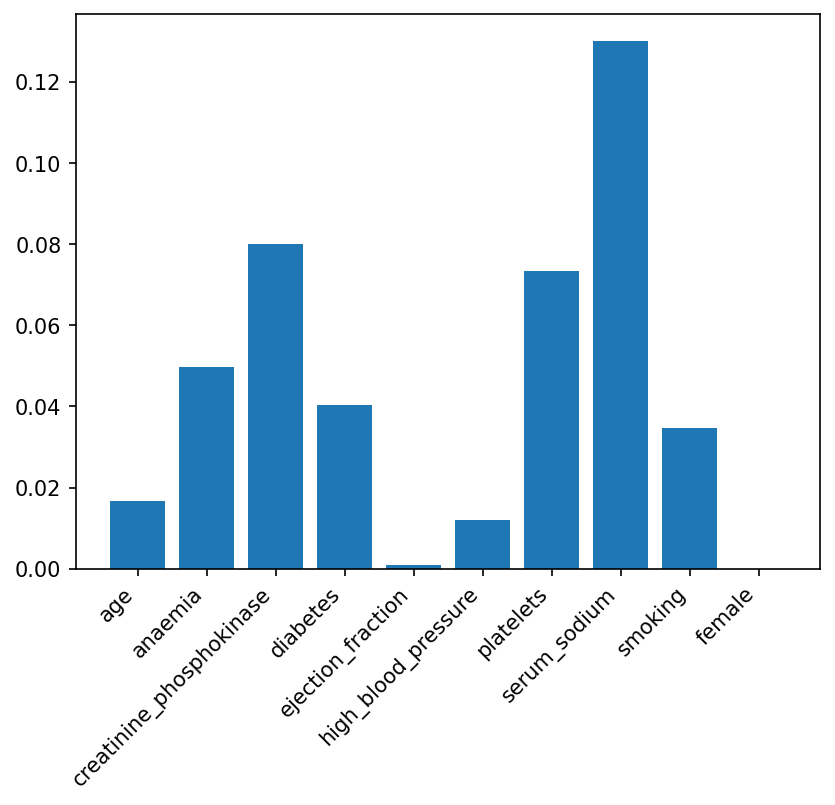

In [11]:
from sklearn.feature_selection import mutual_info_regression

fig, ax = plt.subplots(dpi=150)

correlation = mutual_info_regression(X_train, y_train, random_state=42)

ax.bar(X.columns.values, correlation)
ax.set_xticklabels(X.columns.values, rotation=45, ha='right')

plt.show()

In [12]:
X_train = X_train[:, correlation > 0.05]
X_val   = X_val[:, correlation > 0.05]
X_test  = X_test[:, correlation > 0.05]

y_train = y_train.to_numpy()
y_val   = y_val.to_numpy()
y_test  = y_test.to_numpy()

In [13]:
fig = make_subplots(rows=1, cols=X_train.shape[1])
for i in range(X_train.shape[1]):
    fig.add_trace(
        go.Box(y=X_train[:, i],
        name=X.columns.values[correlation > 0.05][i]),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

> What are the conclusions? (1-2 paragraphs)

Não precisamos de todas as features para prever o valor desejado. O procedimento de reduzir o número de features utilizadas no modelo é chamado de feature selection e é utilizado para reduzir o custo computacional do algoritmo e melhorar sua performance. Com esse método, features redundantes ou que são irrelevantes para o valor alvo são ignoradas. Com isso, ocorre uma melhora de performance no modelo porque do contrário, como não temos regularização, o modelo tentará aprender padrões a partir de features não correlacionadas, o que é computacionalmente caro e pode impactar negativamente nos resultados obtidos.

2. (2.0 points) Perform Linear Regression. You should implement your solution and compare it with ```sklearn.linear_model.SGDRegressor``` (linear model fitted by minimizing a regularized empirical loss with SGD, http://scikit-learn.org).

In [14]:
def MSE(y, y_hat):
    n_samples = len(y)
    return np.sum((y - y_hat)**2)/(2*n_samples) 

In [15]:
class LinearRegression:
    def __init__(self, learning_rate=1., max_iter=-1):
        self.max_iter        = max_iter
        self.learning_rate   = learning_rate
        self.weights         = None
    
    def predict(self, X):
        return X @ self.weights
    
    def fit(self, X, y, *validation_tuple, batch_size=None, summary=True, patience=-1):
        n_iter = 0

        n_samples, n_features = X.shape
        n_output = y.shape[1] if len(y.shape) > 1 else 1

        stopper = 0
        best_error = np.inf

        history  = []
        val_hist = []

        if self.weights is None:
            self.weights = np.zeros((n_features, n_output)) if len(y.shape) > 1 else np.zeros(n_features)

        if validation_tuple:
            X_val, y_val = validation_tuple

        if batch_size is None or batch_size > n_samples:
            batch_size = n_samples

        n_batches = n_samples // batch_size
        while n_iter < self.max_iter:

            loss = 0

            shuffled_indices = np.random.permutation(n_samples)

            for i in range(n_batches):
                batch_indices = shuffled_indices[i*batch_size : min((i+1)*batch_size, n_samples)]

                X_train = X[batch_indices]
                y_train = y[batch_indices]

                batch_current_size = len(batch_indices)

                y_hat = X_train @ self.weights

                error = y_hat - y_train

                weights_grad = (X_train.T @ error)/batch_current_size

                self.weights = self.weights - self.learning_rate * weights_grad

                loss += np.sum(error**2)/(2*batch_current_size)

                history.append(loss/n_batches)

            n_iter += 1

            if summary:
                print(f"Epoch {n_iter : <3d}: Training loss    {loss/n_batches :.5f}")

            if validation_tuple:
                error = (X_val @ self.weights) - y_val

                loss = np.sum(error**2)/(2*y_val.shape[0])
                val_hist.append(loss)

                if summary:
                    print(" "*10, f"Validation loss {loss : .5f}")

                if patience > 0:
                    if loss <= best_error:
                        best_weights = self.weights.copy()
                        stopper = 0
                        best_error = loss
                    
                    else:
                        stopper += 1

                    if stopper > patience:
                        self.weights = best_weights
                        break
                
                    

            if summary: print()

        return history, val_hist if validation_tuple else history


    def loss(self, X, y):
        y_hat = (X @ self.weights)

        return MSE(y, y_hat)


    def score(self, X, y):
        n_samples = len(y)

        y_mean = y.mean(axis=0)

        mean_loss = np.sum((y - y_mean)**2)/(2*n_samples)

        return 1 - self.loss(X, y)/mean_loss

In [16]:
from sklearn.preprocessing import PolynomialFeatures

def eval_model(learning_rate, polynomial_degree=1, verbose=True, max_iter=100, patience=-1):
    global X_train, X_val, y_train, y_val

    if polynomial_degree > 1:
        poly = PolynomialFeatures(polynomial_degree)

        Xt = poly.fit_transform(X_train)
        Xv = poly.transform(X_val)

    else:
        Xt = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
        Xv = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
    
    lin = LinearRegression(learning_rate, max_iter=max_iter)
    history, val_history = lin.fit(Xt, y_train, Xv, y_val, summary=verbose, patience=patience)

    return history, val_history, lin

In [17]:
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val_bias   = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

lin = LinearRegression(0.01, max_iter=200)
history, val_history = lin.fit(X_train_bias, y_train, X_val_bias, y_val)

Epoch 1  : Training loss    1.46600
           Validation loss  1.40106

Epoch 2  : Training loss    1.44552
           Validation loss  1.38228

Epoch 3  : Training loss    1.42544
           Validation loss  1.36391

Epoch 4  : Training loss    1.40577
           Validation loss  1.34594

Epoch 5  : Training loss    1.38649
           Validation loss  1.32837

Epoch 6  : Training loss    1.36759
           Validation loss  1.31118

Epoch 7  : Training loss    1.34907
           Validation loss  1.29437

Epoch 8  : Training loss    1.33092
           Validation loss  1.27793

Epoch 9  : Training loss    1.31313
           Validation loss  1.26185

Epoch 10 : Training loss    1.29570
           Validation loss  1.24612

Epoch 11 : Training loss    1.27861
           Validation loss  1.23074

Epoch 12 : Training loss    1.26186
           Validation loss  1.21571

Epoch 13 : Training loss    1.24545
           Validation loss  1.20100

Epoch 14 : Training loss    1.22937
           Vali

In [18]:
# TODO: Linear Regression. You can use scikit-learn libraries.
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor(learning_rate='constant', eta0=0.01, verbose=1)

regressor.fit(X_train, y_train)

print(f'\nMSE Sklearn: {MSE(regressor.predict(X_val), y_val)}')

X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

print(f'MSE LinearRegression: {MSE(lin.predict(X_val_bias), y_val)}')

-- Epoch 1
Norm: 0.30, NNZs: 3, Bias: 1.169603, T: 191, Avg. loss: 0.731176
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.32, NNZs: 3, Bias: 1.391343, T: 382, Avg. loss: 0.454697
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.32, NNZs: 3, Bias: 1.348629, T: 573, Avg. loss: 0.451197
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 3, Bias: 1.367024, T: 764, Avg. loss: 0.452061
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 3, Bias: 1.418959, T: 955, Avg. loss: 0.448326
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 3, Bias: 1.405595, T: 1146, Avg. loss: 0.453524
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 3, Bias: 1.388598, T: 1337, Avg. loss: 0.450462
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 0.31, NNZs: 3, Bias: 1.364967, T: 1528, Avg. loss: 0.452075
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 0.32, NNZs: 3, Bias: 1.403766, T: 1719, Avg. loss: 0.450557
Total training time: 0.00 second

> What are the conclusions? (1-2 paragraphs)

Ao implementar nosso modelo e comparar o MSE com o do modelo nativo ao Sklearn, podemos observar que o desempenho é bastante próximo. É possível visualizar o mesmo comportamento em ambas as implementações pelos valores de loss ao longo das épocas. Ao final do treino (época 200 para nossa implementação e época 9 para a do sklearn) os valores para validação e treino são similares, como é mostrado acima.

As duas implementações divergem quanto a eficiência: Um mesmo learning rate obteve um mesmo resultado, mas em diferentes números de iterações. A implementação feita por nós leva 200 iterações para obter um caráter de convergência parecido com o do obtido pela implementação do sklearn em apenas 10 épocas.

3. (0.5 points) Plot the cost function vs. number of epochs in the training/validation set and analyze the model. 

[]

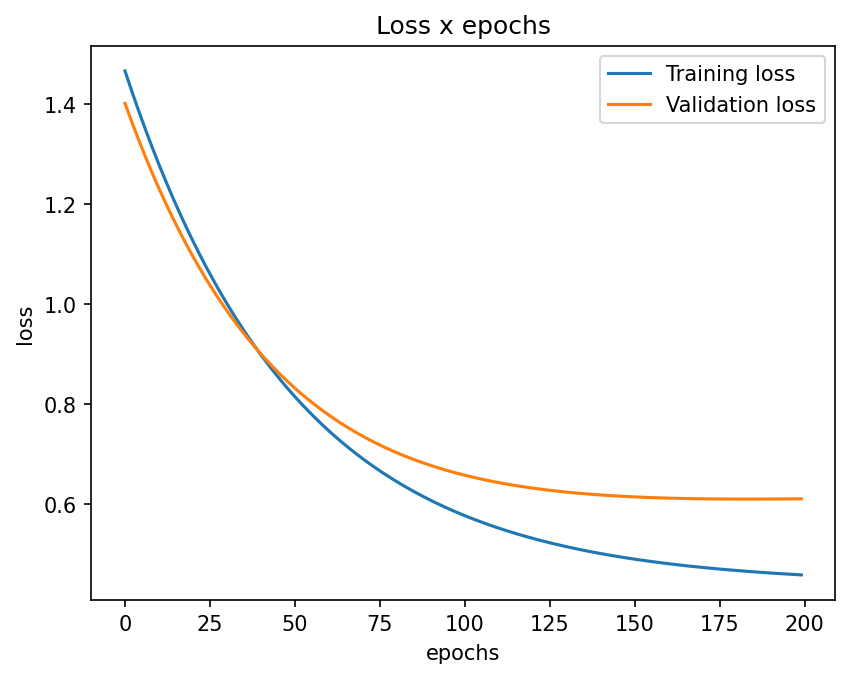

In [19]:
fig, ax = plt.subplots(dpi=150)

ax.plot(history, label="Training loss")
ax.plot(val_history, label="Validation loss")
ax.set_title("Loss x epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()

plt.plot()

> What are the conclusions? (1-2 paragraphs)

Analisando a curva de treinamento do modelo linear, é possível ver uma queda no erro de ambos os conjuntos de validação e treino. Um primeiro comportamento é visto até a época 50, onde os erros de validação e treino decrescem juntos e de forma acentuada. Após isso, tal comportamento é interrompido e o erro de treino continua decrescendo rapidamente, enquanto o erro de validação começa a se estabilizar e finalmente se mantém estável a partir da 150ª época de treinamento, em que passa a não decrescer. O modelo apresenta um encaixe sobre os dados de treino, generalizando de forma razoável, talvez ainda de forma subajustada.

4. (0.75 points) Use different learning rates when optimizing the model. You can use the model that you implemented or the model from scikit-learn.

> If you prefer to use the SGDRegressor from scikit-learn, use the parameter ```learning_rate='constant'``` and change the ```eta0```.

[]

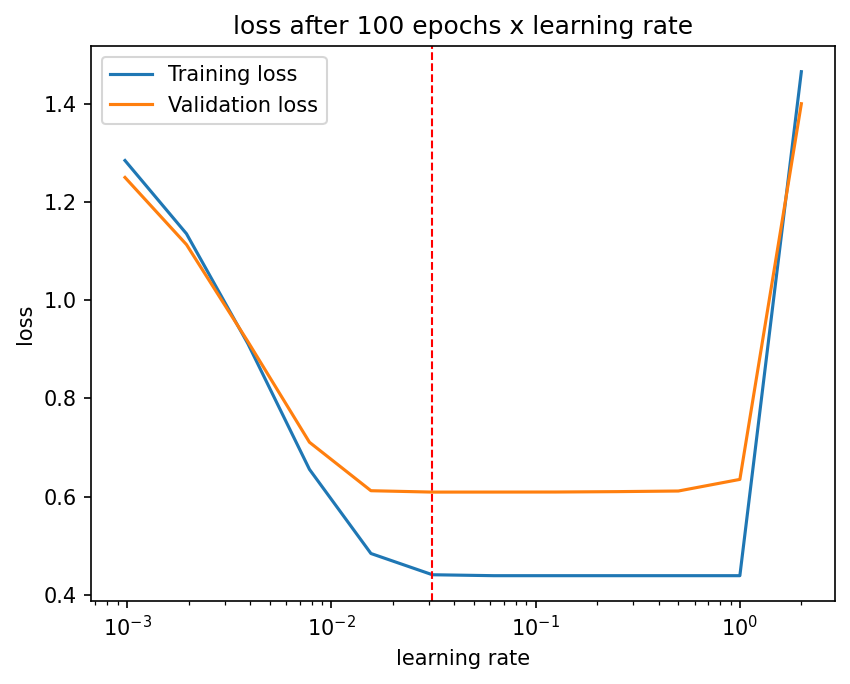

In [20]:
rates = [2**i for i in range(-10, 2)]

train_error = []
val_error = []

for rate in rates:
    history, val_history, _ = eval_model(rate, verbose=False, max_iter=100)

    train_error.append(np.min(history))
    val_error.append(np.min(val_history))

best = rates[np.argmin(val_error)]

fig, ax = plt.subplots(dpi=150)

ax.set_title("loss after 100 epochs x learning rate")
ax.plot(rates, train_error, label="Training loss")
ax.plot(rates, val_error, label="Validation loss")
ax.set_xlabel('learning rate')
ax.set_ylabel('loss')
ax.set_xscale('log')
ax.axvline(best, linestyle='--', linewidth=1, color='r')
ax.legend()
plt.plot()

[]

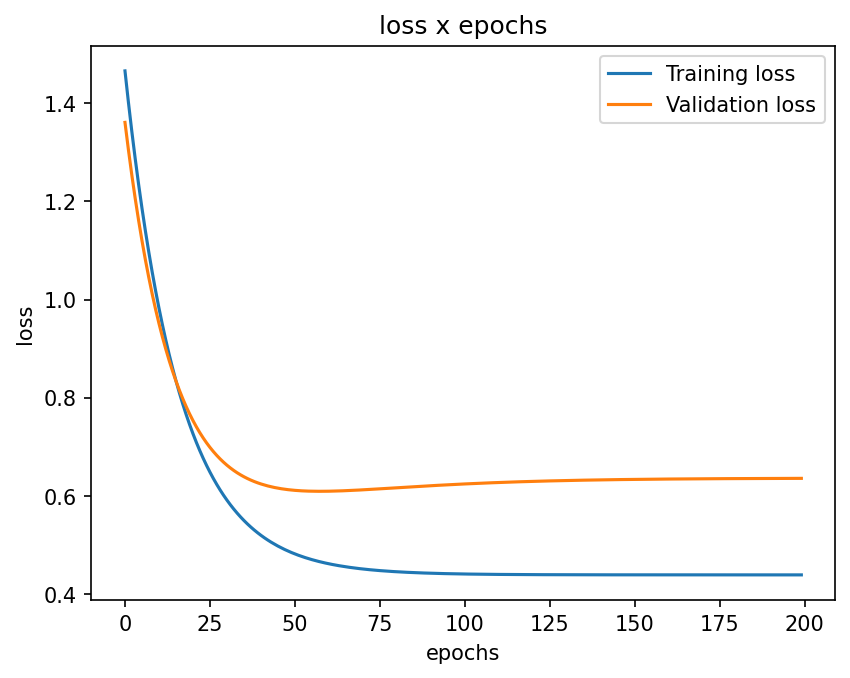

In [21]:
history, val_history, _ = eval_model(learning_rate=best, max_iter=200, verbose=False)
fig, ax = plt.subplots(dpi=150)

ax.plot(history, label="Training loss")
ax.plot(val_history, label="Validation loss")

ax.set_title("loss x epochs")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

ax.legend()
plt.plot()

> What are the conclusions? (1-2 paragraphs)

Para encontrar um learning rate apropriado realizamos uma busca de em grade unidimensional. Nesta técnica, treinamos vários modelos com taxas de aprendizado diferentes e avaliamos a qualidade de cada através de um conjunto de validação separado. Os resultados podem ser vistos no gráfico loss after 100 epochs x learning rate, que correlaciona taxas de aprendizado altas com erros altos devido a overshooting. Uma taxa de aprendizado foi selecionada se a performance do modelo que a utiliza como hiperparâmetro foi a melhor dentre as taxas de aprendizado testadas. Com este procedimento encontramos um learning rate apropriado, de forma a não ocorrer overshooting e não necessitar de uma grande quantidade de épocas para a convergência.

Analisando a curva de treinamento acima, vemos que os comportamentos observados ocorrem em épocas anteriores e o modelo obtém um resultado semelhante com menos iterações, apesar de ainda apresentar o comportamento de underfitting, evidenciado pelo platô do erro de validação.

5. (0.5 points) Sometimes, we need some more complex function to make good prediction. Evaluate a [Polynomial Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) model. 

[]

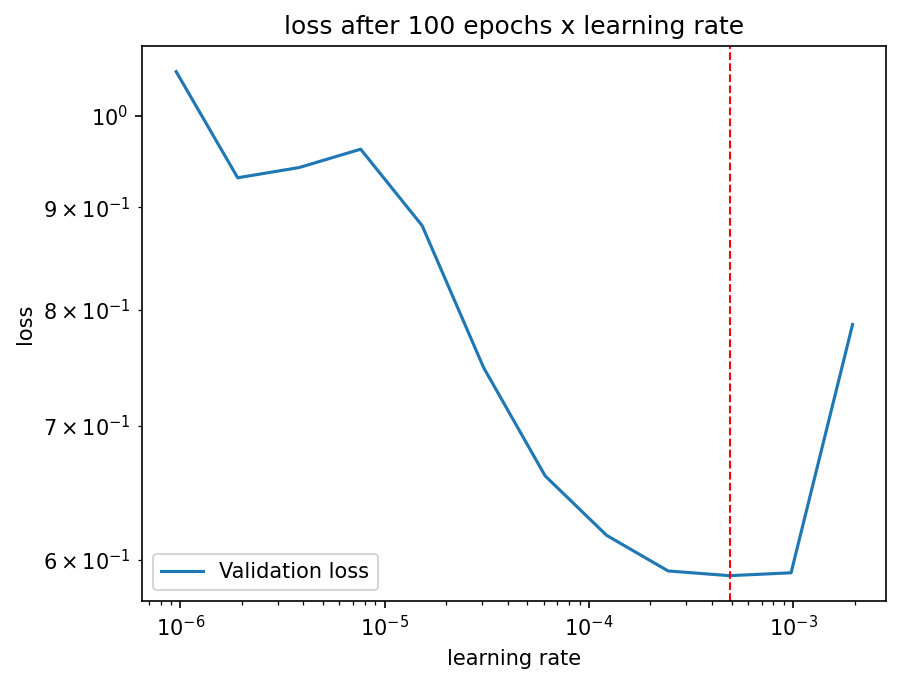

In [22]:
rates = [2**i for i in range(-20, -8)]

train_error = []
val_error = []

X_poly     = PolynomialFeatures(2).fit_transform(X_train)
X_val_poly = PolynomialFeatures(2).fit_transform(X_val)

for rate in rates:
    model = SGDRegressor(eta0=rate, learning_rate='constant', random_state=42)
    model.fit(X_poly, y_train)

    val_error.append(np.min(MSE(model.predict(X_val_poly), y_val)))

best = rates[np.argmin(val_error)]

fig, ax = plt.subplots(dpi=150)

ax.set_title("loss after 100 epochs x learning rate")
ax.plot(rates, val_error, label="Validation loss")
ax.set_xlabel('learning rate')
ax.set_ylabel('loss')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(best, linestyle='--', linewidth=1, color='r')
ax.legend()
plt.plot()

[]

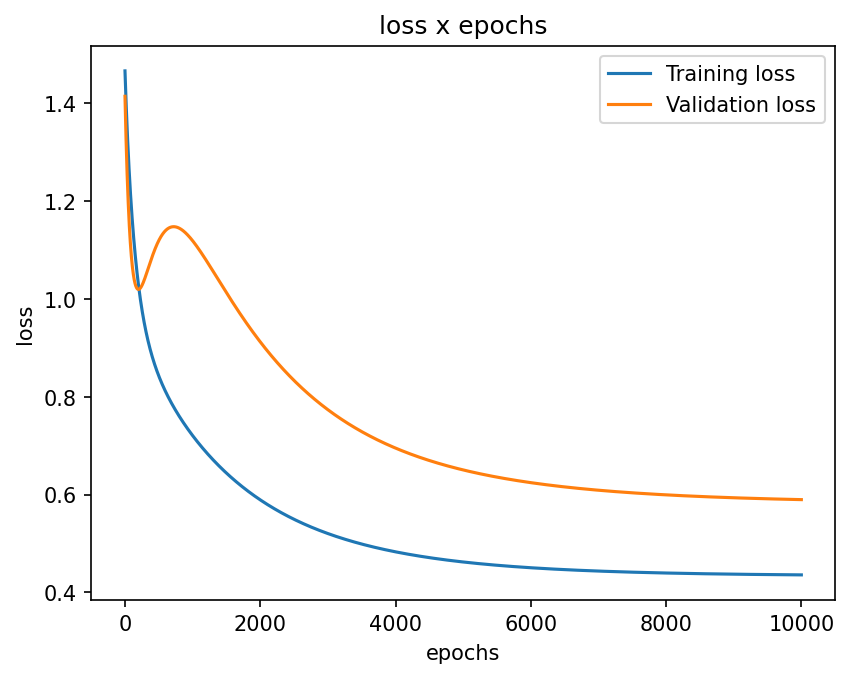

In [23]:
history, val_history, model = eval_model(best, 2, max_iter=10000, verbose=False)

fig, ax = plt.subplots(dpi=150)

ax.plot(history, label="Training loss")
ax.plot(val_history, label="Validation loss")

ax.set_title("loss x epochs")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

ax.legend()
plt.plot()

> What are the conclusions? (1-2 paragraphs)

O modelo quadrático obteve um comportamento semelhante ao modelo linear, mantendo uma diferença entre os valores de loss de treinamento e validação. No entanto, uma quantidade de épocas maior foi necessária devido a maior quantidade de parâmetros a serem otimizados. Apesar da maior flexibilidade, o erro de validação não decresceu como o erro de treinamento, que se manteve mais baixo que o do modelo linear. Deste modo, é possível concluir que modelo quadrático aprensenta indícios que poderá sofrer overfitting se o modelo for treinado em mais épocas.

Neste sentido, seria interessante otimizar o modelo com regularização, a fim de previnir overfitting, mantendo o erro de validação próximo ao erro de treinamento. Este comportamento pode ser visto ao selecionarmos o melhor modelo, ao propormos regressões polinomiais de maior ordem.

6. (0.5 points) Pick **your best model**, based on your validation set, and predict the target values for the test set.

[]

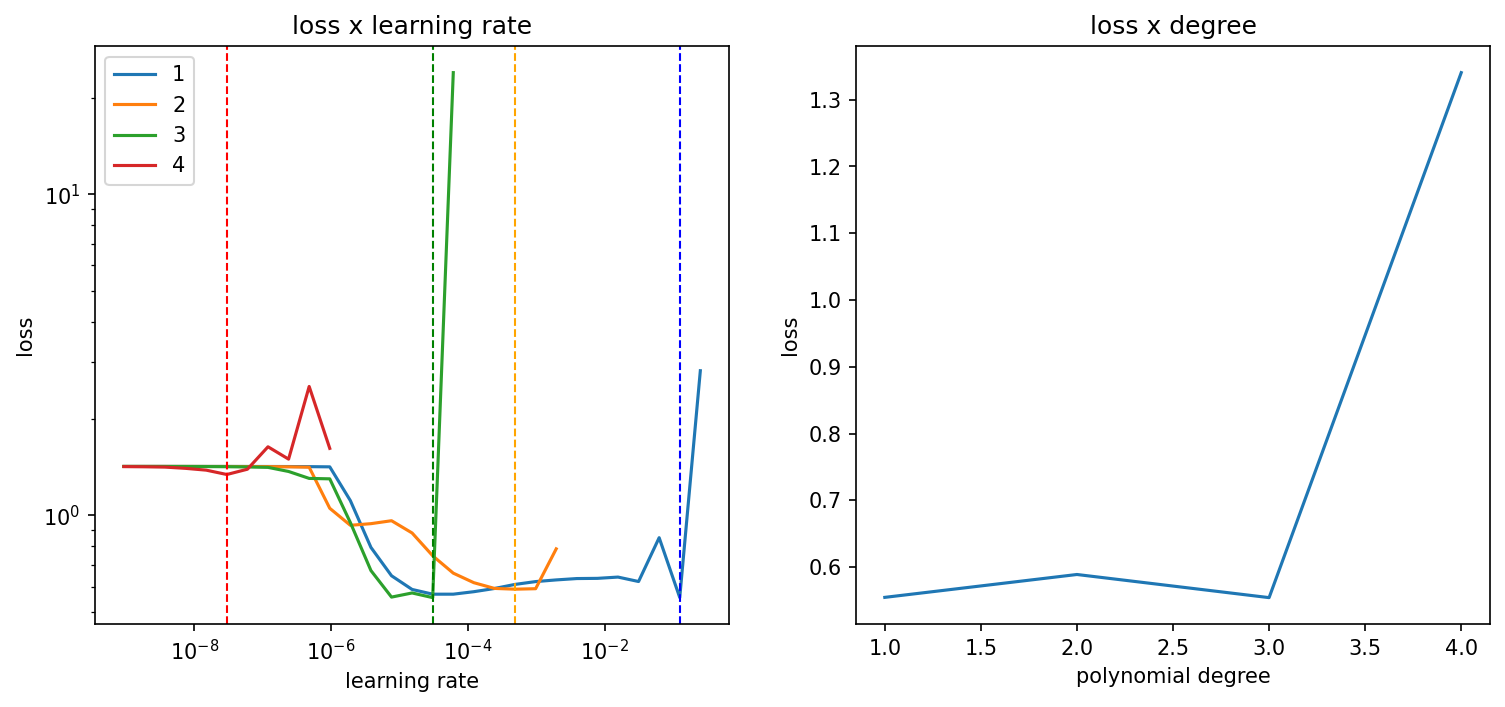

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5) ,dpi=150)

ax[0].set_xlabel('learning rate')
ax[0].set_ylabel('loss')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title("loss x learning rate")
best_model = None
best_error = np.inf
best_degree = 0
best_lr = None

colors = ['blue', 'orange', 'green', 'red', 'purple']

rates = np.array([2**i for i in range(-30, -1)])
degrees = range(1, 5)

val_degree = []
lrs = []
for degree in degrees:
    val_error = []

    if degree == 1:
        X_poly     = X_train_bias
        X_val_poly = X_val_bias

    else:
        X_poly     = PolynomialFeatures(degree).fit_transform(X_train)
        X_val_poly = PolynomialFeatures(degree).fit_transform(X_val)

    for rate in rates:
        model = SGDRegressor(eta0=rate, learning_rate='constant', random_state=42)
        model.fit(X_poly, y_train)

        val_error.append(MSE(model.predict(X_val_poly), y_val))

    best = rates[np.argmin(val_error)]
    val_error = np.array(val_error)
    lrs.append(best)

    ax[0].plot(rates[val_error < 100], val_error[val_error < 100], label=degree)
    ax[0].axvline(best, linestyle='--', linewidth=1, color=colors[degree-1])

    model = SGDRegressor(eta0 = best, learning_rate='constant', random_state=42)
    model.fit(X_poly, y_train)

    val_degree.append(MSE(model.predict(X_val_poly), y_val))

ax[1].plot(degrees, val_degree)
ax[1].set_title("loss x degree")
ax[1].set_xlabel("polynomial degree")
ax[1].set_ylabel("loss")

best_degree = np.argmin(val_degree) + 1

ax[0].legend()
plt.plot()

[]

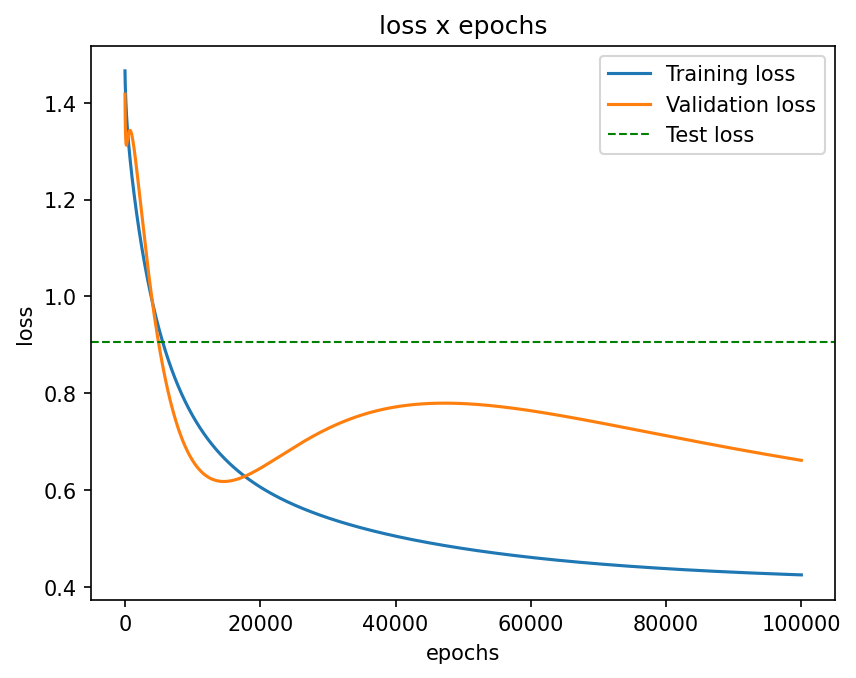

In [25]:
model = LinearRegression(lrs[best_degree-1], max_iter=100000)
history, val_history = model.fit(PolynomialFeatures(best_degree).fit_transform(X_train), y_train, PolynomialFeatures(best_degree).fit_transform(X_val), y_val, summary=False)

fig, ax = plt.subplots(dpi=150)

ax.plot(range(len(history)), history, label="Training loss")
ax.plot(range(len(val_history)), val_history, label="Validation loss")
ax.axhline(MSE(model.predict(PolynomialFeatures(best_degree).fit_transform(X_test)), y_test), linestyle='--', linewidth=1, label="Test loss", color='green')

ax.set_title("loss x epochs")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

ax.legend()

plt.plot()

Selecionamos o modelo polinomial de melhor grau variando a taxa de aprendizado para cada grau e selecionando o modelo que obteve o menor erro de validação. O primeiro gráfico mostra a relação entre taxa de aprendizado e o erro de validação do modelo para cada grau. É possível visualizar que modelos polinomiais de maior grau necessitam de uma taxa de aprendizado cada vez menor, evidenciado pelas retas pontilhadas, que marcam a taxa de aprendizado ótima para cada modelo polinomial. O efeito desta queda na taxa de aprendizado leva a uma convergência mais lenta.

O segundo gráfico mostra os menores erros de validação obtidos pelos modelos polinomiais em relação ao seus graus. Determinamos que o modelo com grau 3 possui o melhor desempenho por esta métrica e o selecionamos para compor o modelo final. O último gráfico mostra o treinamento do modelo selecionado, em que é possível observar a clara tendẽncia em overfitting do modelo mais complexo, além do comportamento de convergência lenta resultado da maior dimensionalidade dos dados. Por fim, avaliamos o modelo final pelo conjunto de teste, que obteve um resultado pior que o esperado. Este fenômeno é consequência da falta de capacidade de generalização do modelo por conta da falta de regularização e também devido a um viés otimista introduzido ao escolhermos o melhor grau em um conjunto de validação separado (holdout).

## Logistic Regression

This part of the assigment aims to predict the patients survival based on their medical records. 

*   Do we need to split the data into train, valid and test? How?
*   Do we need to normalize the data? How? The normalization is equal to train, valid and test split?
* **Target value: DEATH EVENT**.

Assim como na regressão linear realizamos a divisão por treino, validação e teste e pré-processamento dos dados por normalização por Z-score. Os motivos são os mesmos, já que a regressão logística utiliza de um método de otimização iterativo e há a necessidade de se avaliar diversos modelos para definir um modelo final.

In [26]:
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [27]:
from sklearn.preprocessing import StandardScaler

standardization = StandardScaler()

X_train = standardization.fit_transform(X_train)
X_val   = standardization.transform(X_val)
X_test  = standardization.transform(X_test)

1. (0.5 points) Verify if there is any feature that has low correlation with the target variables. You can use the function [mutual_info_classification](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html) to check the importance of each feature.

/tmp/ipykernel_274102/3997655378.py:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



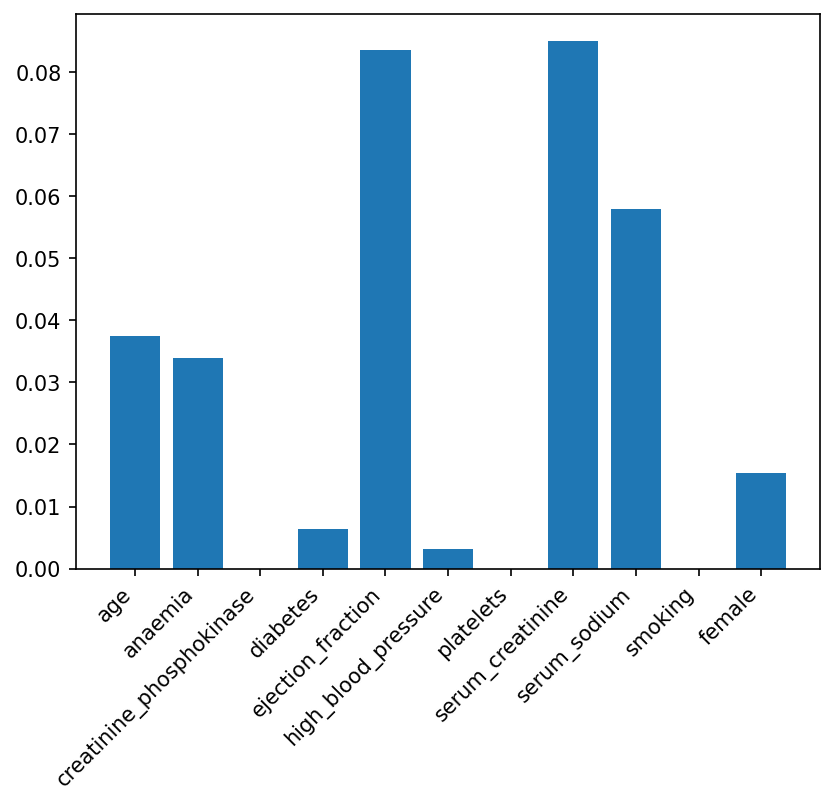

In [28]:
from sklearn.feature_selection import mutual_info_classif

correlation = mutual_info_classif(X_train, y_train, random_state=42) 

fig, ax = plt.subplots(dpi=150)

ax.bar(X.columns.values, correlation)
ax.set_xticklabels(X.columns.values, rotation=45, ha='right')

plt.show()

In [29]:
X_train = X_train[:, correlation > 0.05]
X_val   = X_val[:, correlation > 0.05]
X_test  = X_test[:, correlation > 0.05]

y_train = y_train.to_numpy()
y_val   = y_val.to_numpy()
y_test  = y_test.to_numpy()

> What are the conclusions? (1-2 paragraphs)

Assim como na regressão linear, analisar a correlação das features para a inferência do valor alvo é uma etapa importante para o treino de modelos. Nesta situação, vemos a presença de duas features com alta correlação, ejection fraction e serum creatinine, conforme o artigo da base de dados já previu. As features com correlação superior a 0.05 foram selecionadas e utilizadas para a montagem do modelo.

2. (2 points) Perform Multinomial Logistic Regression.

[]

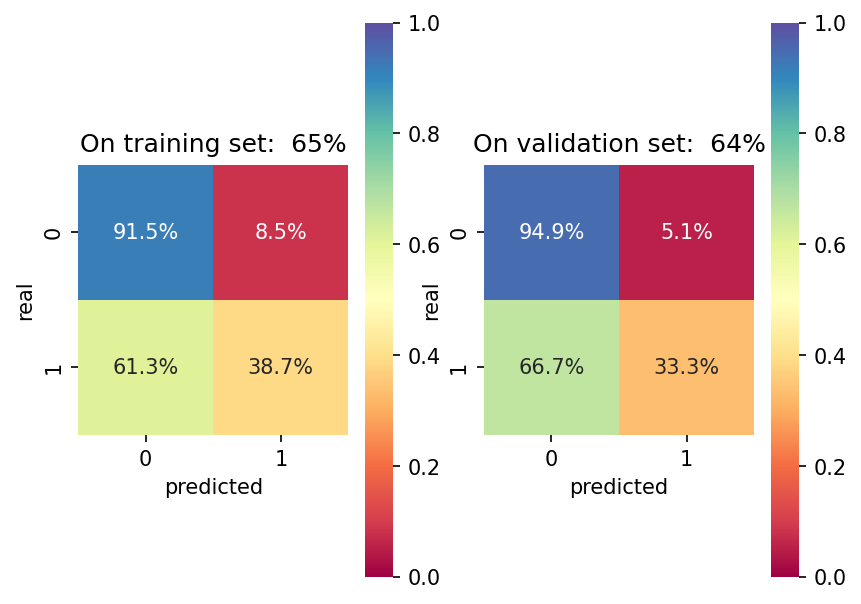

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score


model = LogisticRegression()

model.fit(X_train, y_train)

def confusion_matrix(y_true, y_pred):
    matrix = np.zeros((2,2))

    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    
    return matrix

fig, axs = plt.subplots(ncols=2, dpi=150)


y_pred = model.predict(X_train)

C = confusion_matrix(y_train, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[0], vmin=0, vmax=1)
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_train, y_pred) : 2.0f}%')
axs[0].set_xlabel("predicted")
axs[0].set_ylabel("real")

y_pred = model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[1], vmin=0, vmax=1)
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
axs[1].set_xlabel("predicted")
axs[1].set_ylabel("real")
plt.plot()

> What are the conclusions? (1-2 paragraphs)

O modelo treinado possui uma boa capacidade de prever indivíduos que não morreram, mas possui dificuldade em prever a morte de pacientes. Isso ocorre principalmente devido a um desbalanceamento do conjunto de treinamento, que não possui uma distribuição significativa de ambas as classes, assim, o modelo não performa bem na classe menos representada. Para evitar este tipo de comportamento é necessário balancear o modelo de forma a igualar a representação de cada classe permitindo um treinamento mais homogêneo do classificador. 

3. (1.5 points) Another factor that can alter the model result it's if the dataset is balanced:

*   The dataset is balanced ?
*   In this case, which technique is better: *oversampling* or *undersampling*?

Obs: You can use [RandomOverSampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) and [RandomUnderSampling](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler). But you can try others techniques.

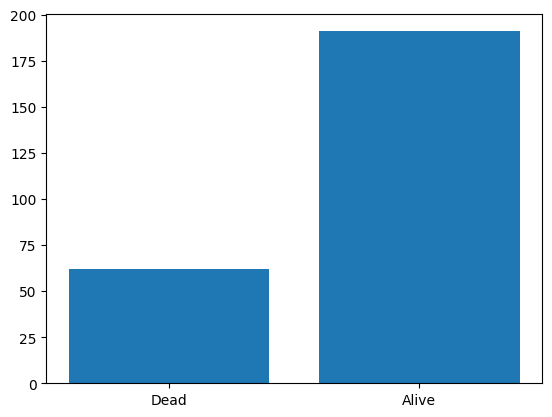

In [31]:
plt.bar(range(2), [np.count_nonzero(y_train), np.count_nonzero(~y_train)])
plt.xticks(range(2), labels=['Dead', 'Alive'])
plt.show()

In [32]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)

X_overtrain, y_overtrain = oversampler.fit_resample(X_train, y_train)

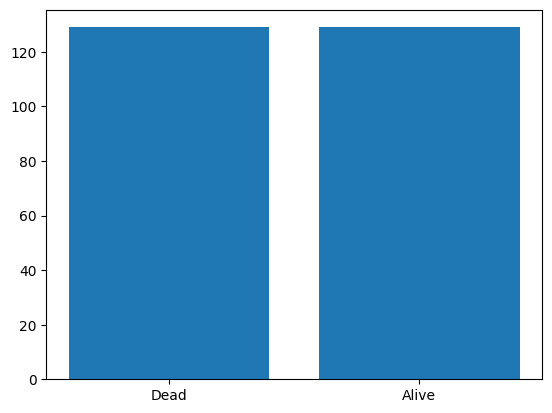

In [33]:
plt.bar(range(2), [np.count_nonzero(y_overtrain), np.count_nonzero(1 - y_overtrain)])
plt.xticks(range(2), labels=['Dead', 'Alive'])
plt.show()

[]

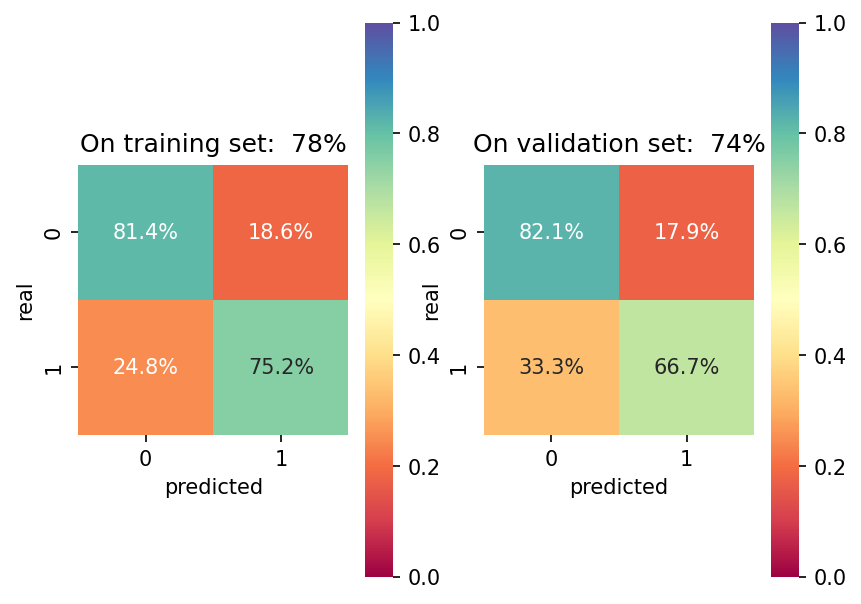

In [34]:
over_model = LogisticRegression()

over_model.fit(X_overtrain, y_overtrain)

fig, axs = plt.subplots(ncols=2, dpi=150)

y_pred = over_model.predict(X_overtrain)

C = confusion_matrix(y_overtrain, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[0], vmin=0, vmax=1)
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_overtrain, y_pred) : 2.0f}%')
axs[0].set_xlabel("predicted")
axs[0].set_ylabel("real")

y_pred = over_model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[1], vmin=0, vmax=1)
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
axs[1].set_xlabel("predicted")
axs[1].set_ylabel("real")
plt.plot()

In [35]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)

X_undertrain, y_undertrain = undersampler.fit_resample(X_train, y_train)

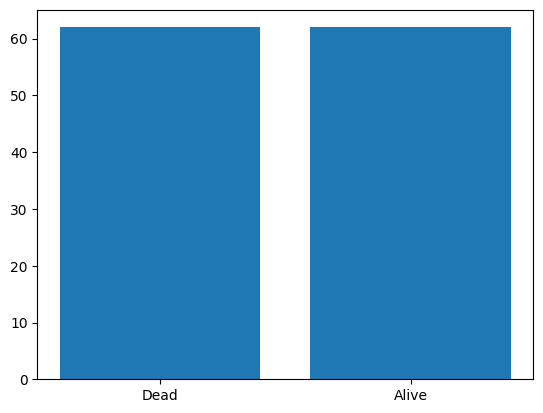

In [36]:
plt.bar(range(2), [np.count_nonzero(y_undertrain), np.count_nonzero(1 - y_undertrain)])
plt.xticks(range(2), labels=['Dead', 'Alive'])
plt.show()

[]

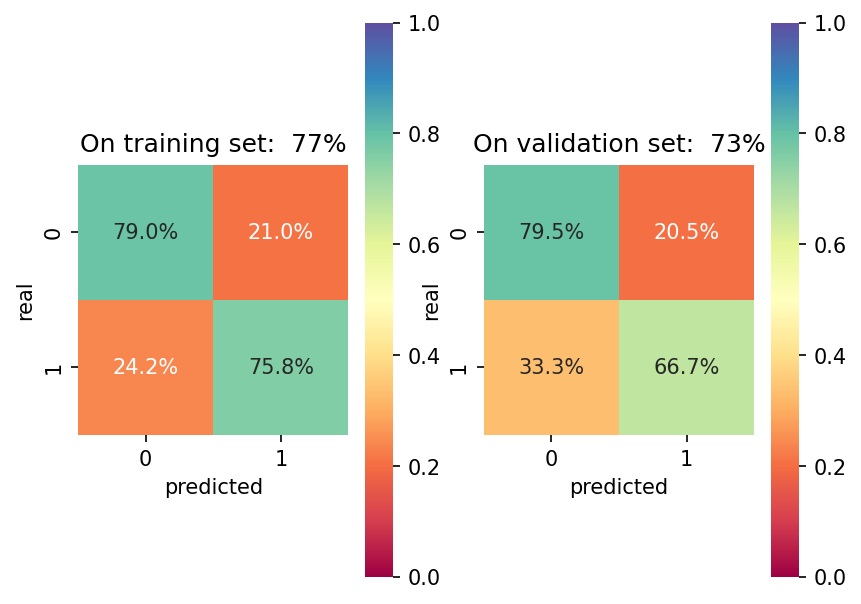

In [37]:
under_model = LogisticRegression()

under_model.fit(X_undertrain, y_undertrain)

def confusion_matrix(y_true, y_pred):
    matrix = np.zeros((2,2))

    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    
    return matrix


fig, axs = plt.subplots(ncols=2, dpi=150)

y_pred = under_model.predict(X_undertrain)

C = confusion_matrix(y_undertrain, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[0], vmin=0, vmax=1)
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_undertrain, y_pred) : 2.0f}%')
axs[0].set_xlabel("predicted")
axs[0].set_ylabel("real")

y_pred = under_model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[1], vmin=0, vmax=1)
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
axs[1].set_xlabel("predicted")
axs[1].set_ylabel("real")
plt.plot()

[]

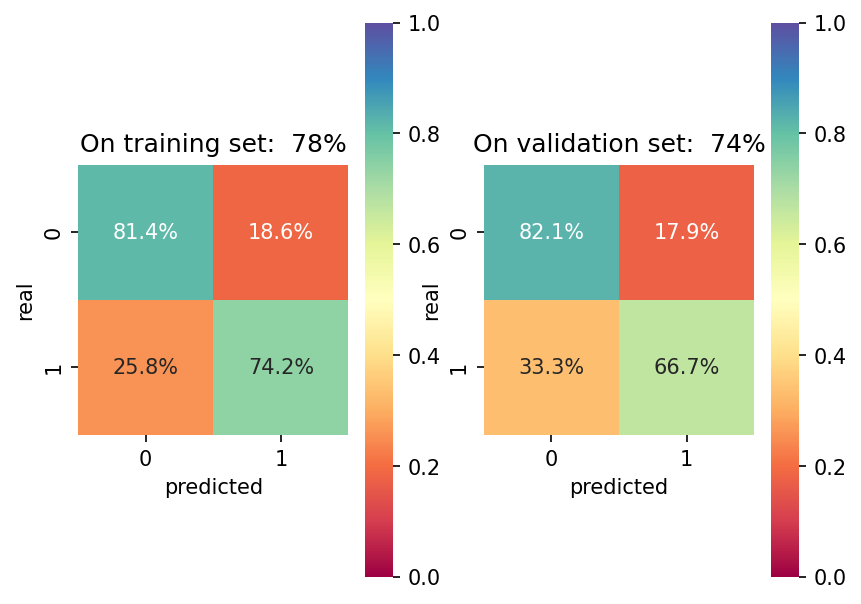

In [38]:
model = LogisticRegression(class_weight='balanced')

model.fit(X_train, y_train)

fig, axs = plt.subplots(ncols=2, dpi=150)


y_pred = model.predict(X_train)

C = confusion_matrix(y_train, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[0], vmin=0, vmax=1)
axs[0].set_title(f'On training set: {100* balanced_accuracy_score(y_train, y_pred) : 2.0f}%')
axs[0].set_xlabel("predicted")
axs[0].set_ylabel("real")

y_pred = model.predict(X_val)

C = confusion_matrix(y_val, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[1], vmin=0, vmax=1)
axs[1].set_title(f'On validation set: {100* balanced_accuracy_score(y_val, y_pred) : 2.0f}%')
axs[1].set_xlabel("predicted")
axs[1].set_ylabel("real")

plt.plot()

> What are the conclusions? (1-2 paragraphs)

É possível visualizar pela primeira figura que o dataset possui uma grande disparidade entre amostras de cada classe, havendo quase três vezes mais amostras de casos negativos que positivos para a label DEATH EVENT. Testamos três formas para solucionar este problema, oversampling, que visa gerar dados sintéticos a partir dos dados já existentes de forma a compensar esta disparidade, undersampling, que remove dados da classe predominante e a técnica de balanceamento de pesos, que atribui pesos no treinamento inversamente proporcionais às frequências de cada classe.

De acordo com nossos testes, a técnica que obteve resultado mais satisfatório foi oversampling, que alcançou maior acurácia balanceada e maior precisão em cada classe. Um dos motivos desta melhor performance pode ser devido a maior quantidade de dados de treinamento, mesmo que sintéticos. A melhora, no entanto, não é acentuada pois o dataset, mesmo depois do oversampling, ainda é pequeno.

4. (0.5 points) Pick **your best model** and plot the confusion matrix in the **test set**. 


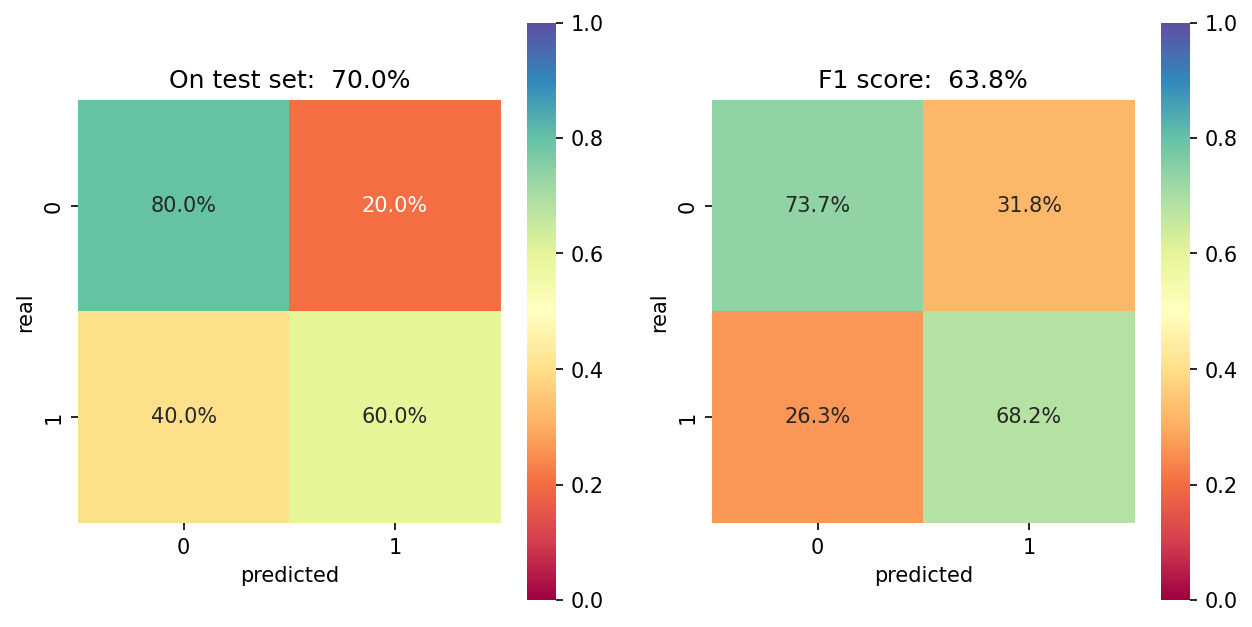

In [39]:
model = LogisticRegression()

model.fit(np.vstack([X_overtrain, X_val]), np.hstack([y_overtrain, y_val]))

fig, axs = plt.subplots(ncols=2, figsize=(10,5), dpi=150)

y_pred = model.predict(X_test)

C = confusion_matrix(y_test, y_pred)
sns.heatmap(C/C.sum(axis=1)[:, None], cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[0], vmin=0, vmax=1)
axs[0].set_title(f'On test set: {balanced_accuracy_score(y_test, y_pred) : .1%}')
axs[0].set_xlabel("predicted")
axs[0].set_ylabel("real")

sns.heatmap(C/C.sum(axis=0), cmap='Spectral', annot=True, fmt='.1%', square=True, ax=axs[1], vmin=0, vmax=1)
axs[1].set_title(f'F1 score: {f1_score(y_test, y_pred) : .1%}')
axs[1].set_xlabel("predicted")
axs[1].set_ylabel("real")

plt.show()

> What are the conclusions? (1-2 paragraphs)

Por fim, avaliamos o modelo selecionado no conjunto de teste treinado sobre todo o conjunto de treino e validação, obtendo os resultados acima. A primeira matriz de confusão indica os valores de precisão do modelo, enquanto a segunda indica os valores de recall junto com seu F1 score. O classificador não obteve resultados impressionantes provalvemente devido a falta de flexibilização do modelo junto a quantidade limitada de dados disponíveis.

## Deadline

Wednesday, April 19, 11:59 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- April 20, 11:59 pm : grade * 0.75
- April 21, 11:59 pm : grade * 0.5
- April 22, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**